## Setup & Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import joblib

from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

import xgboost as xgb
from scipy.stats import uniform, randint

# Settings
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

plt.style.use('default')
sns.set_palette("pastel")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

def plot_boxplots(data, features, title_suffix="", cols=4):
    n_features = len(features)

    rows = (n_features + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))

    if rows > 1:
        axes = axes.flatten()
    elif cols > 1:
        axes = axes.flatten()
    else:
        axes = [axes]

    for idx, feature in enumerate(features):
        sns.boxplot(data=data, y=feature, ax=axes[idx])

        mean_val = data[feature].mean()
        median_val = data[feature].median()

        axes[idx].axhline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
        axes[idx].axhline(median_val, color='green', linestyle='-', linewidth=2, label=f'Median: {median_val:.2f}')

        axes[idx].set_title(f"{feature} {title_suffix}")
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)

    for idx in range(n_features, len(axes)):
        axes[idx].set_visible(False)

    plt.tight_layout()
    plt.show()

print("Setup complete - All libraries imported and seed set")

Setup complete - All libraries imported and seed set


##  Load Data & Verify BMI Integrity

In [ ]:
df = pd.read_csv('/content/DiaBD.csv')

df['bmi_check'] = df['weight'] / (df['height'] ** 2)

bmi_diff = abs(df['bmi'] - df['bmi_check'])
problematic_bmi = bmi_diff > 0.1

print(f" BMI Integrity Check:")
print(f"   - Records with BMI difference > 0.1: {problematic_bmi.sum()}")
print(f"   - Maximum difference: {bmi_diff.max():.4f}")

if problematic_bmi.any():
    df.loc[problematic_bmi, 'bmi'] = df.loc[problematic_bmi, 'bmi_check']
    print(f"   -  Corrected {problematic_bmi.sum()} BMI values")

df.drop(columns=['bmi_check'], inplace=True)

print(f"\n Dataset loaded successfully:")
print(f"   - Shape: {df.shape}")
print(f"   - Columns: {df.columns.tolist()}")
df.head()

 BMI Integrity Check:
   - Records with BMI difference > 0.1: 1954
   - Maximum difference: 13.9448
   -  Corrected 1954 BMI values

 Dataset loaded successfully:
   - Shape: (5288, 15)
   - Columns: ['age', 'gender', 'pulse_rate', 'systolic_bp', 'diastolic_bp', 'glucose', 'height', 'weight', 'bmi', 'family_diabetes', 'hypertensive', 'family_hypertension', 'cardiovascular_disease', 'stroke', 'diabetic']


,age,gender,pulse_rate,systolic_bp,diastolic_bp,glucose,height,weight,bmi,family_diabetes,hypertensive,family_hypertension,cardiovascular_disease,stroke,diabetic
0,42,Female,66,110,73,5.88,1.65,70.2,25.750000,0,0,0,0,0,No
1,35,Female,60,125,68,5.71,1.47,42.5,19.580000,0,0,0,0,0,No
2,62,Female,57,127,74,6.85,1.52,47.0,20.342798,0,0,0,0,0,No
3,73,Male,55,193,112,6.28,1.63,57.4,21.604125,0,0,0,0,0,No
4,68,Female,71,150,81,5.71,1.42,36.0,17.790000,0,0,0,0,0,No


## Target Distribution Analysis

 Target Variable Distribution:
   - No Diabetes (No): 4946 (93.5%)
   - Diabetes (Yes): 342 (6.5%)
   - Imbalance Ratio: 14.46:1


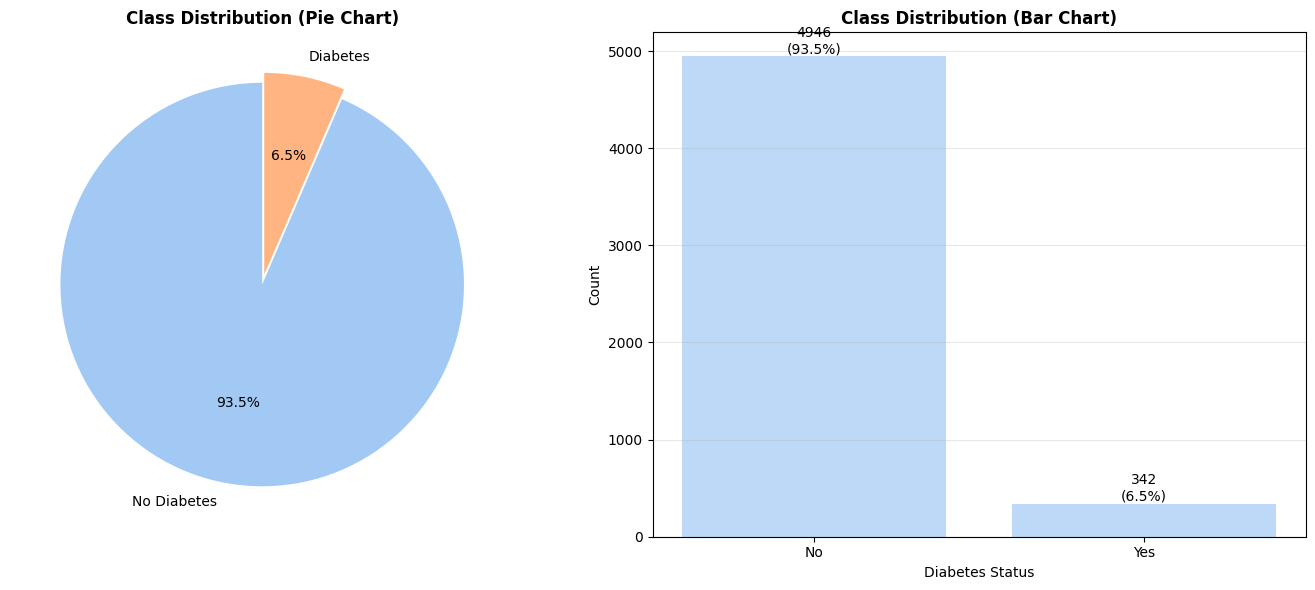

In [ ]:
target_counts = df['diabetic'].value_counts()
target_percentages = df['diabetic'].value_counts(normalize=True) * 100

print(" Target Variable Distribution:")
print(f"   - No Diabetes (No): {target_counts['No']} ({target_percentages['No']:.1f}%)")
print(f"   - Diabetes (Yes): {target_counts['Yes']} ({target_percentages['Yes']:.1f}%)")
print(f"   - Imbalance Ratio: {max(target_counts) / min(target_counts):.2f}:1")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].pie(target_counts.values,
            labels=['No Diabetes', 'Diabetes'],
            autopct='%1.1f%%',
            startangle=90,
            explode=(0, 0.05))
axes[0].set_title('Class Distribution (Pie Chart)', fontweight='bold')

bars = axes[1].bar(target_counts.index, target_counts.values, alpha=0.7)
axes[1].set_title('Class Distribution (Bar Chart)', fontweight='bold')
axes[1].set_xlabel('Diabetes Status')
axes[1].set_ylabel('Count')
axes[1].grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                 f'{int(height)}\n({height/len(df)*100:.1f}%)',
                 ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Missing Values & Duplicates

In [ ]:
missing_values = df.isnull().sum()
print("Missing Values Check:")
if missing_values.any():
    print(missing_values[missing_values > 0])
else:
    print("   No missing values found")

duplicate_count = df.duplicated().sum()
print(f"\n Duplicates Check:")
print(f"   - Duplicate rows: {duplicate_count}")

Missing Values Check:
   No missing values found

 Duplicates Check:
   - Duplicate rows: 0


## Original Feature Outlier Detection

 Original Feature Outlier Counts (IQR Method):
   - age            :    0 outliers ( 0.00%)
   - pulse_rate     :   96 outliers ( 1.82%)
   - systolic_bp    :  113 outliers ( 2.14%)
   - diastolic_bp   :   54 outliers ( 1.02%)
   - glucose        :  400 outliers ( 7.56%)
   - height         :  193 outliers ( 3.65%)
   - weight         :   79 outliers ( 1.49%)
   - bmi            :  136 outliers ( 2.57%)

 Original Feature Boxplots:


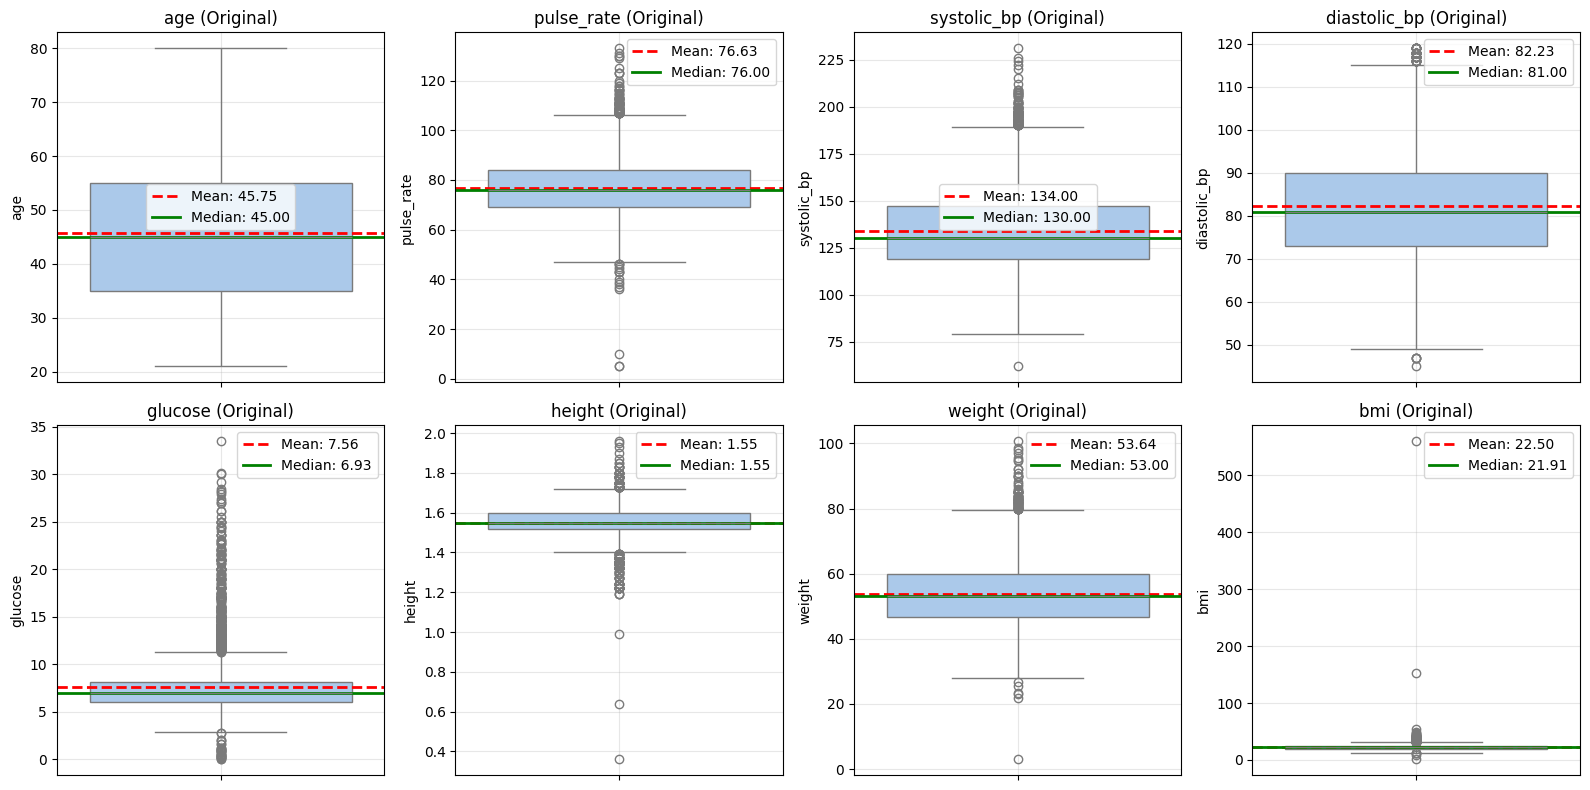

In [ ]:
numerical_features = ['age', 'pulse_rate', 'systolic_bp', 'diastolic_bp',
                      'glucose', 'height', 'weight', 'bmi']

def count_outliers_iqr(data, features):
    outlier_info = {}

    for feature in features:
        Q1 = data[feature].quantile(0.25)
        Q3 = data[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = data[(data[feature] < lower_bound) | (data[feature] > upper_bound)]
        outlier_info[feature] = len(outliers)

    return outlier_info

print(" Original Feature Outlier Counts (IQR Method):")
outlier_counts = count_outliers_iqr(df, numerical_features)
for feature, count in outlier_counts.items():
    percentage = (count / len(df)) * 100
    print(f"   - {feature:15s}: {count:4d} outliers ({percentage:5.2f}%)")

print("\n Original Feature Boxplots:")
plot_boxplots(df, numerical_features, "(Original)")

## Train-Test Split

In [ ]:
X = df.drop(columns=['diabetic'])
y = df['diabetic']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=y
)

print(f"   - Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f"   - Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(df)*100:.1f}%)")

print("\n Class Distribution After Split:")
for name, y_set in [("Train", y_train), ("Test", y_test)]:
    counts = y_set.value_counts()
    percentages = y_set.value_counts(normalize=True) * 100
    print(f"   - {name:5s}: No={counts.get('No',0)} ({percentages.get('No',0):.1f}%), Yes={counts.get('Yes',0)} ({percentages.get('Yes',0):.1f}%)")

   - Training set: 4230 samples (80.0%)
   - Test set: 1058 samples (20.0%)

 Class Distribution After Split:
   - Train: No=3956 (93.5%), Yes=274 (6.5%)
   - Test : No=990 (93.6%), Yes=68 (6.4%)


## Target Encoding

In [ ]:
target_mapping = {'Yes': 1, 'No': 0}

y_train_encoded = y_train.map(target_mapping)
y_test_encoded = y_test.map(target_mapping)

print(f"   - Mapping: {target_mapping}")
print(f"   - y_train: {y_train_encoded.value_counts().to_dict()}")
print(f"   - y_test: {y_test_encoded.value_counts().to_dict()}")

assert not y_train_encoded.isnull().any(), "Target encoding failed for training set!"
assert not y_test_encoded.isnull().any(), "Target encoding failed for test set!"

   - Mapping: {'Yes': 1, 'No': 0}
   - y_train: {0: 3956, 1: 274}
   - y_test: {0: 990, 1: 68}


## Critical Medical Filters

In [ ]:
# physiologically impossible ranges
medical_filters = {
    'height': (1.0, 2.2),      # meters
    'weight': (30, 200),       # kg
    'pulse_rate': (40, 180),   # bpm
    'bmi': (10, 60),           # kg/m²
    'glucose': (2, 20)         # mmol/L
}

original_train_size = len(X_train)

for feature, (min_val, max_val) in medical_filters.items():
    before_filter = len(X_train)
    mask = (X_train[feature] >= min_val) & (X_train[feature] <= max_val)
    X_train = X_train[mask]
    y_train_encoded = y_train_encoded[mask]
    removed = before_filter - len(X_train)
    print(f"   - {feature:15s}: kept {len(X_train):5d} | removed {removed:3d} (outside {min_val}-{max_val})")

rows_removed = original_train_size - len(X_train)
print(f"\n Filter Summary:")
print(f"   - Original rows: {original_train_size}")
print(f"   - Rows removed: {rows_removed} ({rows_removed/original_train_size*100:.1f}%)")
print(f"   - Final training size: {X_train.shape}")

   - height         : kept  4228 | removed   2 (outside 1.0-2.2)
   - weight         : kept  4223 | removed   5 (outside 30-200)
   - pulse_rate     : kept  4217 | removed   6 (outside 40-180)
   - bmi            : kept  4217 | removed   0 (outside 10-60)
   - glucose        : kept  4147 | removed  70 (outside 2-20)

 Filter Summary:
   - Original rows: 4230
   - Rows removed: 83 (2.0%)
   - Final training size: (4147, 14)


## Winsorization

 Calculating Winsorization Bounds (1st-99th Percentile):
   - systolic_bp    : [  95.00,  196.00]
   - diastolic_bp   : [  56.00,  115.29]
   - pulse_rate     : [  51.00,  109.00]
   - glucose        : [   4.05,   17.04]
   - bmi            : [  14.79,   34.40]
   - height         : [   1.35,    1.73]
   - weight         : [  33.70,   80.86]

 Training Data Boxplots - BEFORE Winsorization:


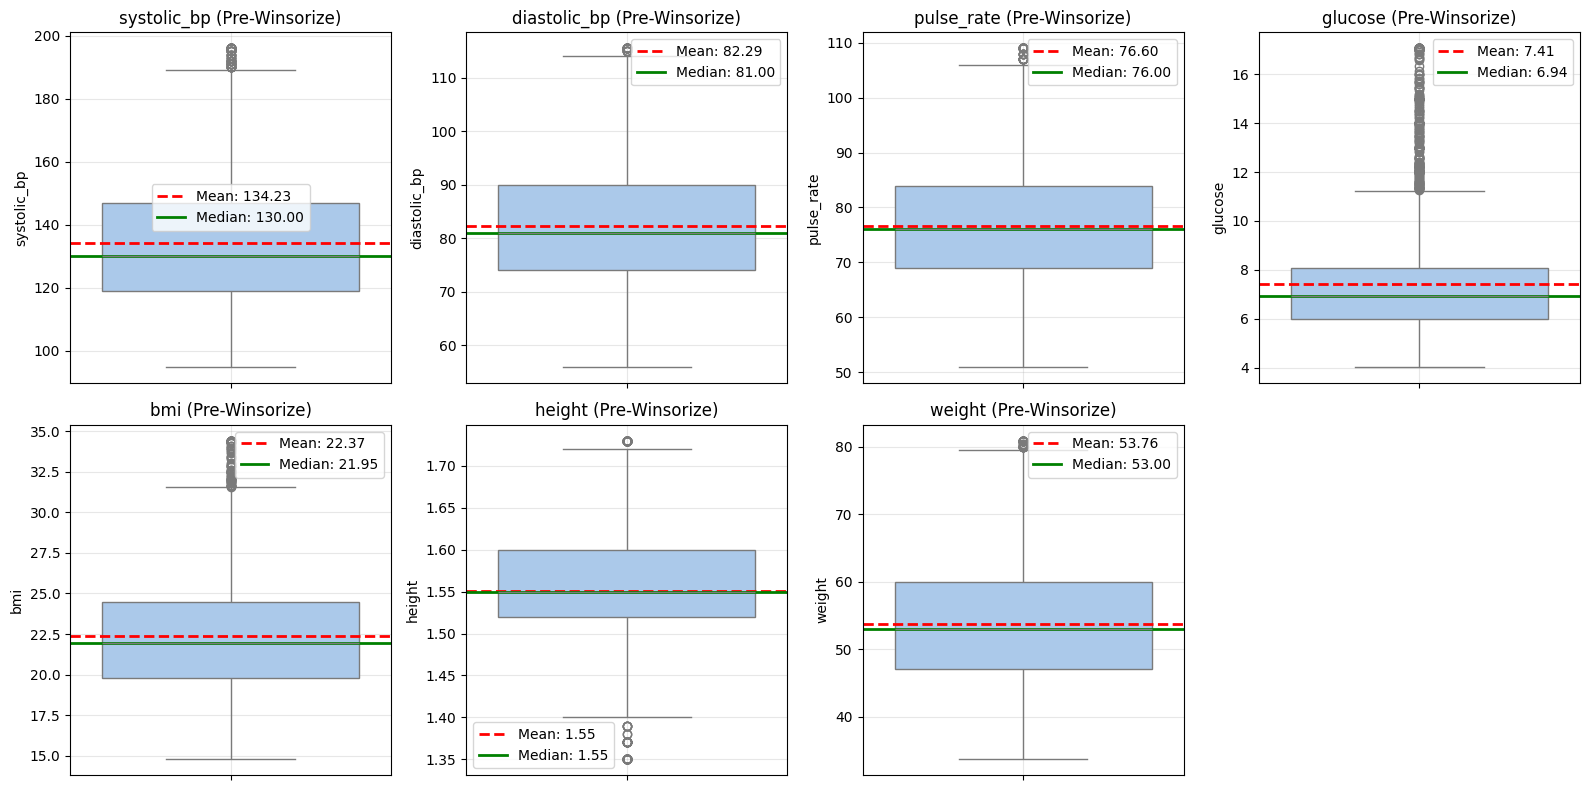


 Applying Winsorization to Train and Test Sets...

 Training Data Boxplots - AFTER Winsorization:


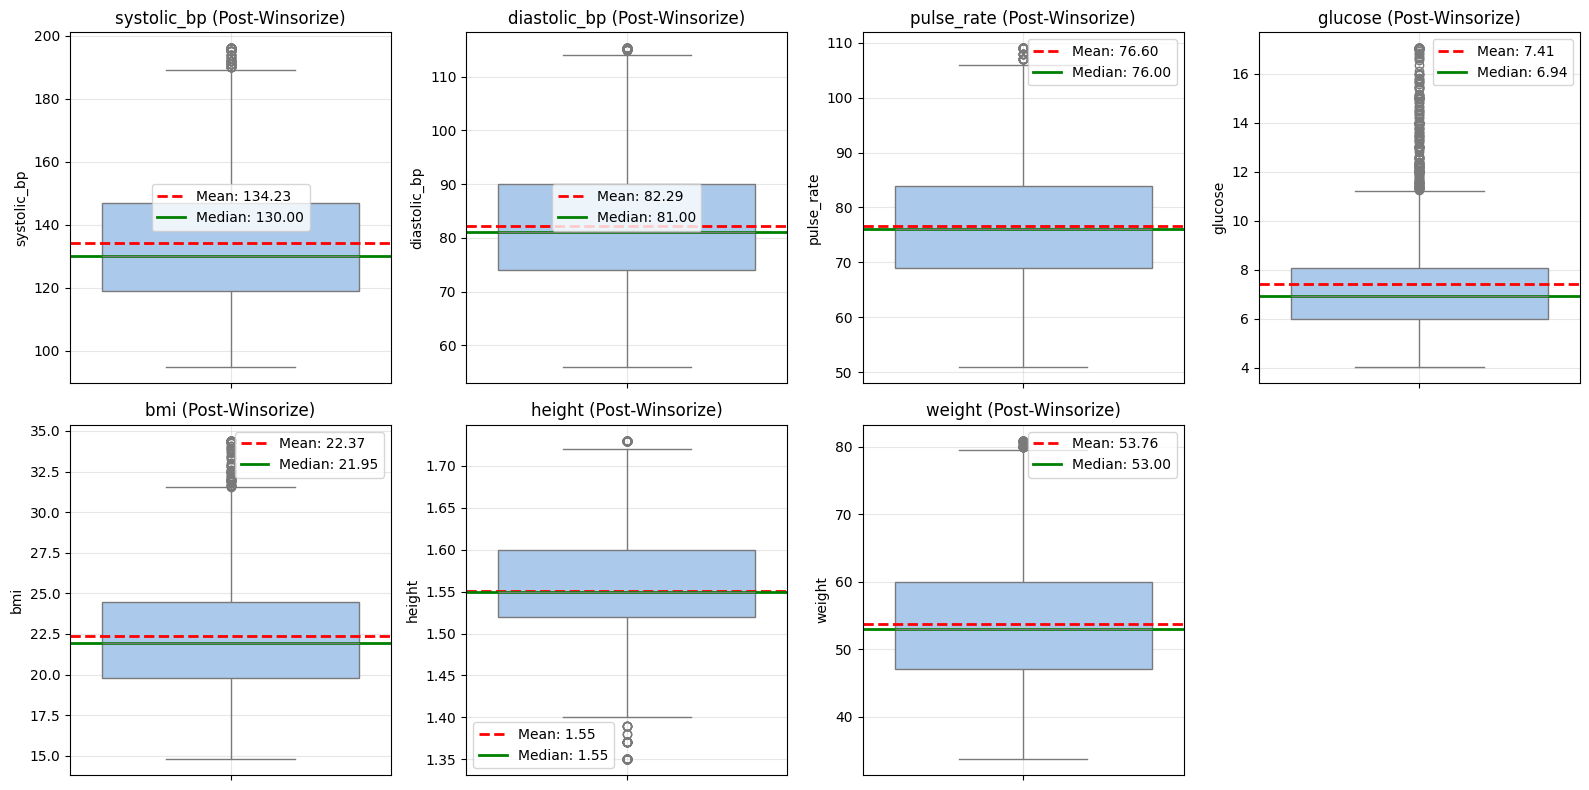

In [ ]:
winsorize_features = ['systolic_bp', 'diastolic_bp', 'pulse_rate',
                      'glucose', 'bmi', 'height', 'weight']

percentiles = {}
print(" Calculating Winsorization Bounds (1st-99th Percentile):")
for feature in winsorize_features:
    lower = X_train[feature].quantile(0.01)
    upper = X_train[feature].quantile(0.99)
    percentiles[feature] = (lower, upper)
    print(f"   - {feature:15s}: [{lower:7.2f}, {upper:7.2f}]")


print("\n Training Data Boxplots - BEFORE Winsorization:")
plot_boxplots(X_train, winsorize_features, "(Pre-Winsorize)")

print("\n Applying Winsorization to Train and Test Sets...")
for feature in winsorize_features:
    lower, upper = percentiles[feature]
    X_train[feature] = X_train[feature].clip(lower=lower, upper=upper)
    X_test[feature] = X_test[feature].clip(lower=lower, upper=upper)

print("\n Training Data Boxplots - AFTER Winsorization:")
plot_boxplots(X_train, winsorize_features, "(Post-Winsorize)")

## Clinical Feature Engineering

In [ ]:
# Pulse Pressure (strong cardiovascular predictor)
X_train['pulse_pressure'] = X_train['systolic_bp'] - X_train['diastolic_bp']
X_test['pulse_pressure'] = X_test['systolic_bp'] - X_test['diastolic_bp']

# Hypertension Flag (clinical threshold)
X_train['hypertension_flag'] = ((X_train['systolic_bp'] >= 140) |
                                (X_train['diastolic_bp'] >= 90)).astype(int)
X_test['hypertension_flag'] = ((X_test['systolic_bp'] >= 140) |
                               (X_test['diastolic_bp'] >= 90)).astype(int)

# Obesity Flag (WHO classification)
X_train['obesity_flag'] = (X_train['bmi'] >= 30).astype(int)
X_test['obesity_flag'] = (X_test['bmi'] >= 30).astype(int)

print(" Clinical Features Engineered:")
print("   - pulse_pressure: systolic_bp - diastolic_bp (cardiovascular risk)")
print("   - hypertension_flag: 1 if sbp≥140 or dbp≥90")
print("   - obesity_flag: 1 if bmi≥30")

print(f"\n New shape after feature engineering:")
print(f"   - X_train: {X_train.shape}")
print(f"   - X_test: {X_test.shape}")

 Clinical Features Engineered:
   - pulse_pressure: systolic_bp - diastolic_bp (cardiovascular risk)
   - hypertension_flag: 1 if sbp≥140 or dbp≥90
   - obesity_flag: 1 if bmi≥30

 New shape after feature engineering:
   - X_train: (4147, 17)
   - X_test: (1058, 17)


## Log Transform & Multicollinearity Cleanup


In [ ]:
X_train['glucose_log'] = np.log1p(X_train['glucose'])
X_test['glucose_log'] = np.log1p(X_test['glucose'])

features_to_drop = ['glucose', 'height', 'weight']

X_train.drop(columns=features_to_drop, inplace=True)
X_test.drop(columns=features_to_drop, inplace=True)

print(f"\n Final feature counts:")
print(f"   - X_train: {X_train.shape[1]} features")
print(f"   - X_test: {X_test.shape[1]} features")


 Final feature counts:
   - X_train: 15 features
   - X_test: 15 features


## BMI Categories & Gender Encoding

In [ ]:
# BMI categories (WHO standards)
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif bmi < 25:
        return 'Normal'
    elif bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'

X_train['bmi_category'] = X_train['bmi'].apply(categorize_bmi)
X_test['bmi_category'] = X_test['bmi'].apply(categorize_bmi)

# One-hot encode BMI categories
bmi_dummies_train = pd.get_dummies(X_train['bmi_category'], prefix='bmi')
bmi_dummies_test = pd.get_dummies(X_test['bmi_category'], prefix='bmi')

# Align columns (ensure both have same dummy columns)
all_bmi_cols = set(bmi_dummies_train.columns) | set(bmi_dummies_test.columns)
for col in all_bmi_cols:
    if col not in bmi_dummies_train.columns:
        bmi_dummies_train[col] = 0
    if col not in bmi_dummies_test.columns:
        bmi_dummies_test[col] = 0

bmi_dummies_train = bmi_dummies_train[sorted(bmi_dummies_train.columns)]
bmi_dummies_test = bmi_dummies_test[sorted(bmi_dummies_test.columns)]

X_train = pd.concat([X_train.drop(columns=['bmi_category']), bmi_dummies_train], axis=1)
X_test = pd.concat([X_test.drop(columns=['bmi_category']), bmi_dummies_test], axis=1)

gender_mapping = {'Female': 0, 'Male': 1}
X_train['gender'] = X_train['gender'].map(gender_mapping)
X_test['gender'] = X_test['gender'].map(gender_mapping)

print(f"   - BMI categories one-hot encoded: {list(bmi_dummies_train.columns)}")
print(f"   - Gender mapped: {gender_mapping}")
print(f"\n Final dataset shapes:")
print(f"   - X_train: {X_train.shape}")
print(f"   - X_test: {X_test.shape}")
print(f"   - Features: {X_train.columns.tolist()}")

   - BMI categories one-hot encoded: ['bmi_Normal', 'bmi_Obese', 'bmi_Overweight', 'bmi_Underweight']
   - Gender mapped: {'Female': 0, 'Male': 1}

 Final dataset shapes:
   - X_train: (4147, 19)
   - X_test: (1058, 19)
   - Features: ['age', 'gender', 'pulse_rate', 'systolic_bp', 'diastolic_bp', 'bmi', 'family_diabetes', 'hypertensive', 'family_hypertension', 'cardiovascular_disease', 'stroke', 'pulse_pressure', 'hypertension_flag', 'obesity_flag', 'glucose_log', 'bmi_Normal', 'bmi_Obese', 'bmi_Overweight', 'bmi_Underweight']


In [ ]:
binary_columns = [
    'gender', 'family_diabetes', 'hypertensive', 'family_hypertension',
    'cardiovascular_disease', 'stroke', 'hypertension_flag', 'obesity_flag'
]

for col in binary_columns:
    if col in X_train.columns:
        unique_vals = X_train[col].unique()
        print(f"   - {col}: unique values {sorted(unique_vals)}")

        X_train[col] = X_train[col].astype(int).astype('category')
        X_test[col] = X_test[col].astype(int).astype('category')
        print(f"     Converted to: {X_train[col].dtype}")

bmi_columns = [col for col in X_train.columns if col.startswith('bmi_')]
for col in bmi_columns:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

print(f"\n Final data types after conversion:")
print(X_train.dtypes.value_counts())

   - gender: unique values [np.int64(0), np.int64(1)]
     Converted to: category
   - family_diabetes: unique values [np.int64(0), np.int64(1)]
     Converted to: category
   - hypertensive: unique values [np.int64(0), np.int64(1)]
     Converted to: category
   - family_hypertension: unique values [np.int64(0), np.int64(1)]
     Converted to: category
   - cardiovascular_disease: unique values [np.int64(0), np.int64(1)]
     Converted to: category
   - stroke: unique values [np.int64(0), np.int64(1)]
     Converted to: category
   - hypertension_flag: unique values [np.int64(0), np.int64(1)]
     Converted to: category
   - obesity_flag: unique values [np.int64(0), np.int64(1)]
     Converted to: category

 Final data types after conversion:
category    8
float64     4
category    4
int64       3
Name: count, dtype: int64


## Multivariate Outlier Detection

In [ ]:
# Useing Isolation Forest for multivariate outlier detection

outlier_features = ['age', 'pulse_rate', 'bmi', 'glucose_log', 'pulse_pressure']

iso_forest = IsolationForest(
    contamination=0.05,
    random_state=RANDOM_SEED
)

outlier_labels = iso_forest.fit_predict(X_train[outlier_features])
outlier_mask = outlier_labels == -1  # -1 indicates outlier

print(f"\n Outlier Detection Results:")
print(f"   - Total training samples: {len(X_train)}")
print(f"   - Detected outliers: {outlier_mask.sum()}")
print(f"   - Percentage: {outlier_mask.mean()*100:.1f}%")

X_train_clean = X_train[~outlier_mask].copy()
y_train_clean = y_train_encoded[~outlier_mask].copy()

print(f"\n Training Set After Outlier Removal:")
print(f"   - Clean training size: {X_train_clean.shape[0]}")
print(f"   - Samples removed: {outlier_mask.sum()}")
print(f"   - Final shape: {X_train_clean.shape}")


 Outlier Detection Results:
   - Total training samples: 4147
   - Detected outliers: 208
   - Percentage: 5.0%

 Training Set After Outlier Removal:
   - Clean training size: 3939
   - Samples removed: 208
   - Final shape: (3939, 19)


## Original Feature Visualizations

## Final Feature Visualizations

 Final Engineered Features
   - Numerical features: ['age', 'pulse_rate', 'systolic_bp', 'diastolic_bp', 'bmi', 'pulse_pressure', 'glucose_log']

 Final Feature Boxplots:


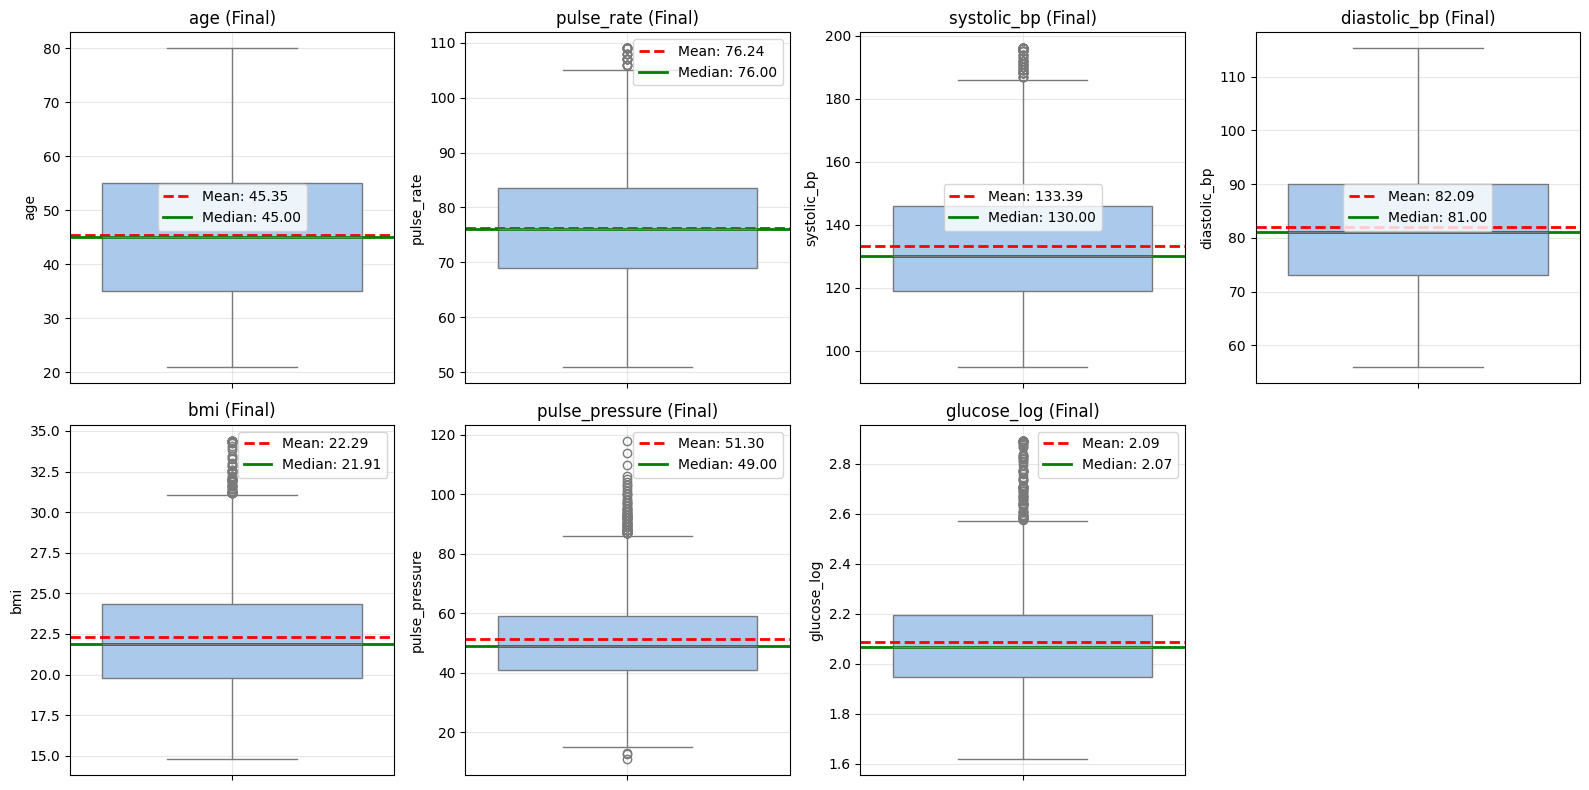

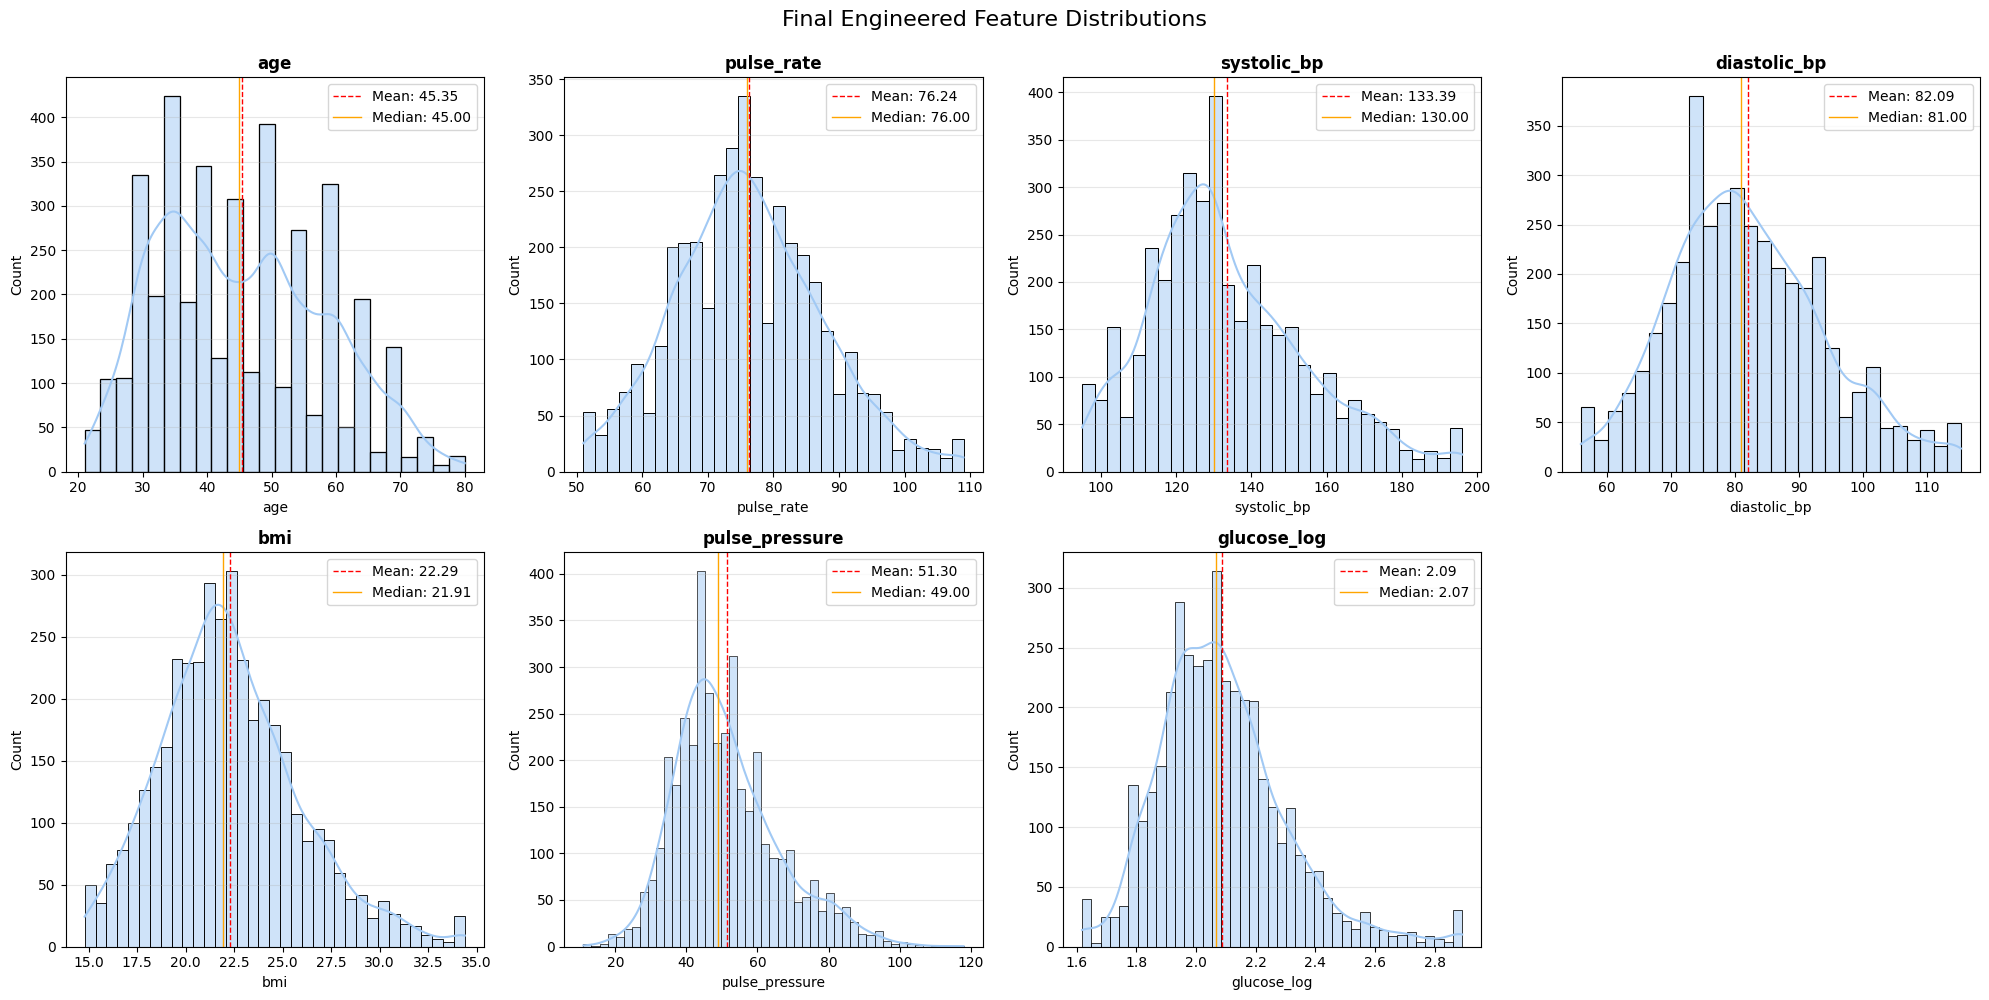

In [ ]:
final_numerical = X_train_clean.select_dtypes(include=[np.number]).columns.tolist()
binary_features = ['hypertension_flag', 'obesity_flag', 'gender']
final_numerical = [col for col in final_numerical if col not in binary_features and 'bmi_' not in col]

print(" Final Engineered Features")
print(f"   - Numerical features: {final_numerical}")

print("\n Final Feature Boxplots:")
plot_boxplots(X_train_clean, final_numerical, "(Final)")

n_cols = len(final_numerical)
fig, axes = plt.subplots(2, (n_cols+1)//2, figsize=(5*(n_cols+1)//2, 10))
if n_cols <= 3:
    axes = axes.flatten()[:n_cols]
else:
    axes = axes.flatten()

for idx, feature in enumerate(final_numerical):
    sns.histplot(data=X_train_clean, x=feature, kde=True, ax=axes[idx])

    mean_val = X_train_clean[feature].mean()
    median_val = X_train_clean[feature].median()

    axes[idx].axvline(mean_val, color='red', linestyle='--', linewidth=1,
                      label=f'Mean: {mean_val:.2f}')
    axes[idx].axvline(median_val, color='orange', linestyle='-', linewidth=1,
                      label=f'Median: {median_val:.2f}')

    axes[idx].set_title(f'{feature}', fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(axis='y', alpha=0.3)

for idx in range(len(final_numerical), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Final Engineered Feature Distributions', fontsize=16, y=0.995)
plt.tight_layout()
plt.show()

## Correlation Analysis

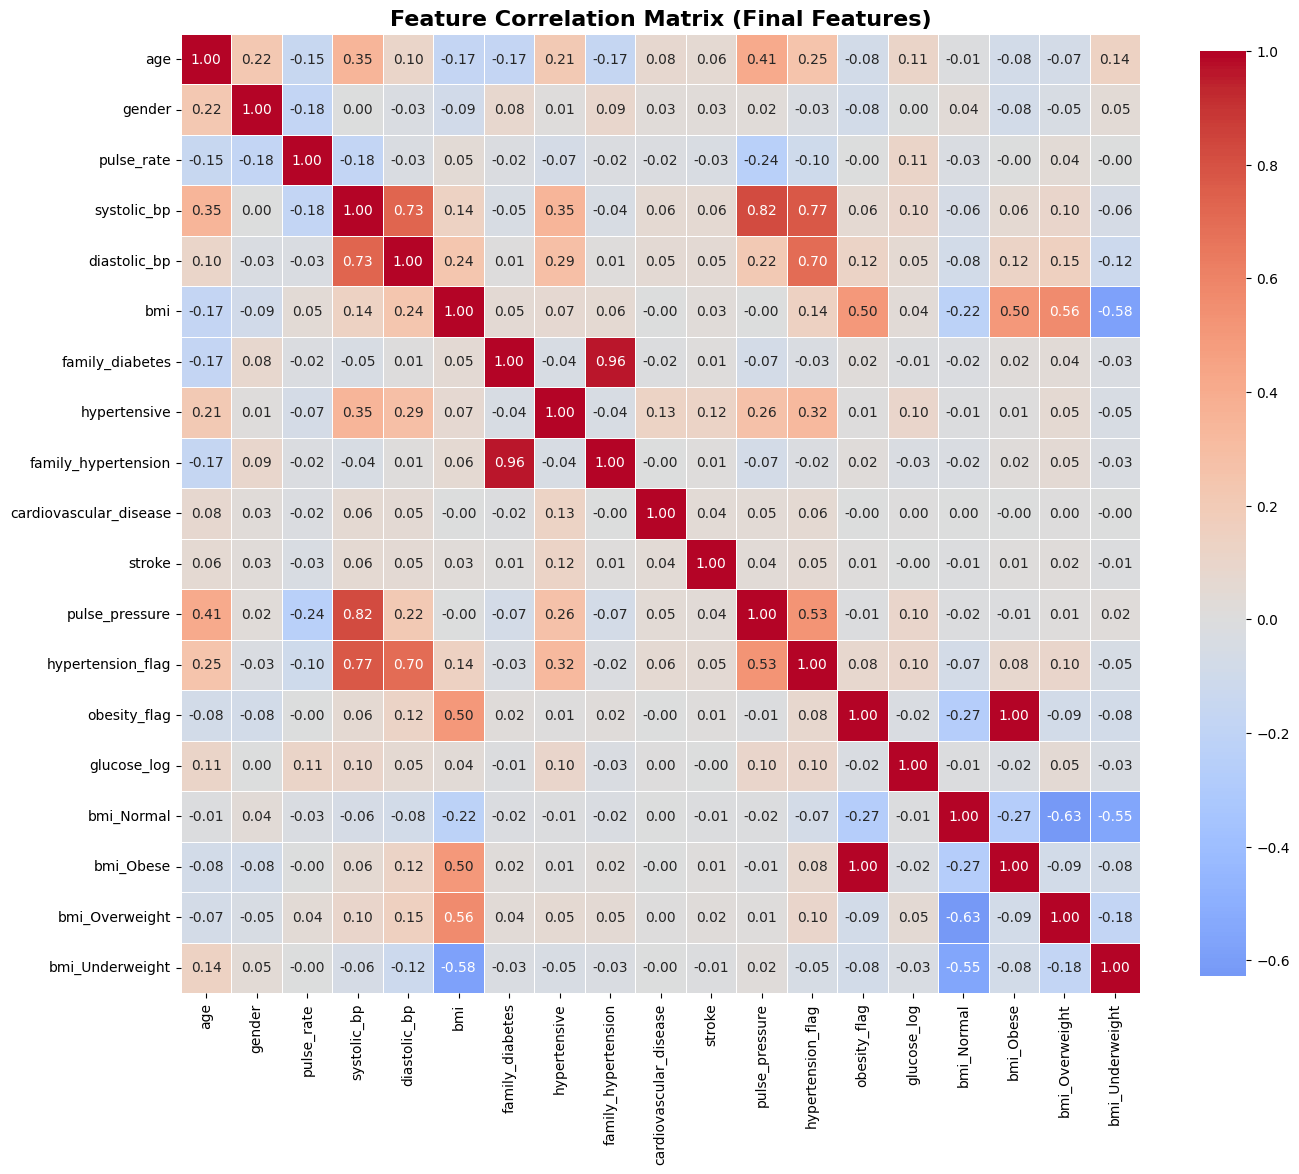

      Feature 1           Feature 2  Correlation
family_diabetes family_hypertension     0.957941
   obesity_flag           bmi_Obese     1.000000
hypertensive              0.353
glucose_log               0.212
systolic_bp               0.160
diastolic_bp              0.157
hypertension_flag         0.149
bmi                       0.101
pulse_pressure            0.099
age                       0.097
cardiovascular_disease    0.079
bmi_Overweight            0.075
bmi_Underweight          -0.066
gender                    0.029
stroke                    0.024
family_diabetes          -0.024
bmi_Obese                 0.024
obesity_flag              0.024
pulse_rate                0.021
bmi_Normal               -0.020
family_hypertension      -0.014
Name: diabetic, dtype: float64


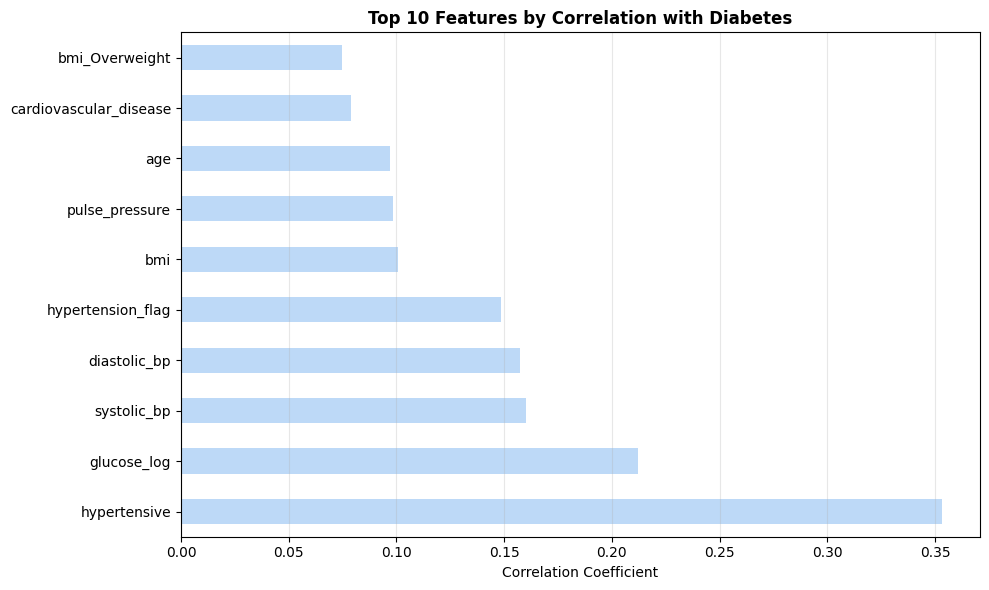

In [ ]:
correlation_matrix = X_train_clean.corr()

fig, ax = plt.subplots(figsize=(14, 12))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.9}, fmt='.2f')

plt.title('Feature Correlation Matrix (Final Features)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

high_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.85:
            high_corr.append({
                'Feature 1': correlation_matrix.columns[i],
                'Feature 2': correlation_matrix.columns[j],
                'Correlation': corr_val
            })

if high_corr:
    high_corr_df = pd.DataFrame(high_corr)
    print(high_corr_df.to_string(index=False))
else:
    print("   No correlations > 0.85 found")

temp_df = X_train_clean.copy()
temp_df['diabetic'] = y_train_clean.values

target_correlations = temp_df.corr()['diabetic'].drop('diabetic').sort_values(key=abs, ascending=False)
print(target_correlations.round(3))

# Plot top 10 correlations
top_10 = target_correlations.head(10)
fig, ax = plt.subplots(figsize=(10, 6))
top_10.plot(kind='barh', ax=ax, alpha=0.7)
ax.set_title('Top 10 Features by Correlation with Diabetes', fontweight='bold')
ax.set_xlabel('Correlation Coefficient')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

    High correlations remaining:
      Feature 1           Feature 2  Correlation
family_diabetes family_hypertension     0.957941


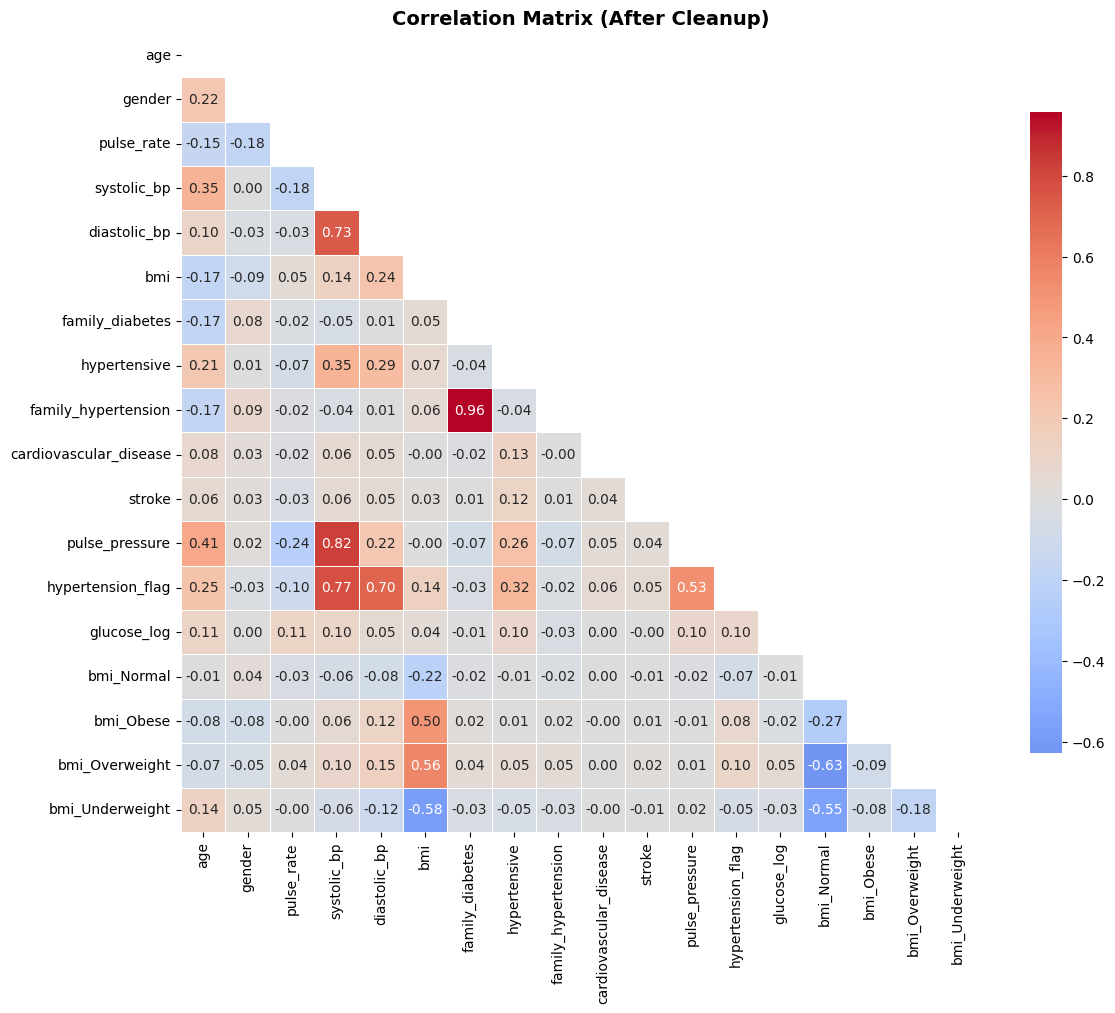


 Final Dataset Shapes After Cleanup:
   - X_train_clean: (3939, 18)
   - X_test_final: (1058, 18)


In [22]:
# Perfect multicollinearity (obesity_flag vs bmi_Obese)
if 'obesity_flag' in X_train_clean.columns:
    X_train_clean.drop(columns=['obesity_flag'], inplace=True)
    X_test.drop(columns=['obesity_flag'], inplace=True)

correlation_matrix_clean = X_train_clean.corr()

# any remaining high correlations (>0.85)
high_corr_remaining = []
for i in range(len(correlation_matrix_clean.columns)):
    for j in range(i+1, len(correlation_matrix_clean.columns)):
        corr_val = correlation_matrix_clean.iloc[i, j]
        if abs(corr_val) > 0.85:
            high_corr_remaining.append({
                'Feature 1': correlation_matrix_clean.columns[i],
                'Feature 2': correlation_matrix_clean.columns[j],
                'Correlation': corr_val
            })

if high_corr_remaining:
    print("    High correlations remaining:")
    high_corr_df = pd.DataFrame(high_corr_remaining)
    print(high_corr_df.to_string(index=False))
else:
    print("    No correlations > 0.85 remaining")

mask = np.triu(np.ones_like(correlation_matrix_clean, dtype=bool))
fig, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(correlation_matrix_clean, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, fmt='.2f')

plt.title('Correlation Matrix (After Cleanup)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n Final Dataset Shapes After Cleanup:")
print(f"   - X_train_clean: {X_train_clean.shape}")
print(f"   - X_test_final: {X_test.shape}")

## Target Imbalance

 Training Set Class Distribution:
   - No Diabetes (0): 3734 samples (94.8%)
   - Diabetes (1): 205 samples (5.2%)
   - Imbalance Ratio: 18.21:1


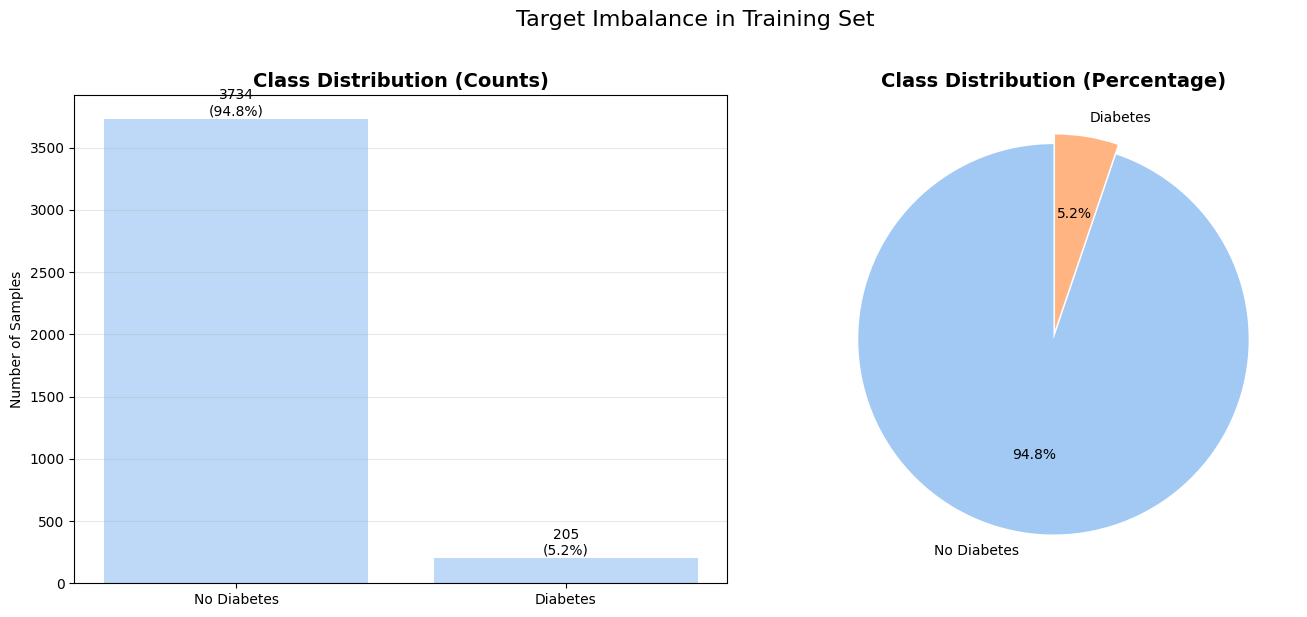

In [23]:
class_counts = y_train_clean.value_counts().sort_index()
class_percentages = (class_counts / len(y_train_clean) * 100).round(1)

print(" Training Set Class Distribution:")
print(f"   - No Diabetes (0): {class_counts[0]} samples ({class_percentages[0]}%)")
print(f"   - Diabetes (1): {class_counts[1]} samples ({class_percentages[1]}%)")
print(f"   - Imbalance Ratio: {class_counts[0] / class_counts[1]:.2f}:1")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

bars = axes[0].bar(['No Diabetes', 'Diabetes'], class_counts.values, alpha=0.7)
axes[0].set_title('Class Distribution (Counts)', fontweight='bold', fontsize=14)
axes[0].set_ylabel('Number of Samples')
axes[0].grid(axis='y', alpha=0.3)

for bar, pct in zip(bars, class_percentages):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                 f'{int(height)}\n({pct}%)', ha='center', va='bottom')

axes[1].pie(class_counts.values, labels=['No Diabetes', 'Diabetes'],
            autopct='%1.1f%%', startangle=90, explode=(0, 0.05))
axes[1].set_title('Class Distribution (Percentage)', fontweight='bold', fontsize=14)

plt.suptitle('Target Imbalance in Training Set', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## Safe Imbalance Handling (No SMOTE)

In [24]:
class_counts = y_train_clean.value_counts().sort_index()
class_percentages = (class_counts / len(y_train_clean) * 100).round(1)

print(" Training Set Class Distribution:")
print(f"   - No Diabetes (0): {class_counts[0]} samples ({class_percentages[0]}%)")
print(f"   - Diabetes (1): {class_counts[1]} samples ({class_percentages[1]}%)")
print(f"   - Imbalance Ratio: {class_counts[0] / class_counts[1]:.2f}:1")

weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train_clean.values
)

class_weight_dict = {0: weights[0], 1: weights[1]}

print("\n using: class_weight='balanced'")
print(f"   - Class 0 weight: {class_weight_dict[0]:.3f}")
print(f"   - Class 1 weight: {class_weight_dict[1]:.3f}")
print("   - This tells models: 'Diabetes samples are 18x more important'")

 Training Set Class Distribution:
   - No Diabetes (0): 3734 samples (94.8%)
   - Diabetes (1): 205 samples (5.2%)
   - Imbalance Ratio: 18.21:1

 using: class_weight='balanced'
   - Class 0 weight: 0.527
   - Class 1 weight: 9.607
   - This tells models: 'Diabetes samples are 18x more important'


## Scale & Train

In [26]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_clean)
X_test_scaled = scaler.transform(X_test)

models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=200,
        random_state=RANDOM_SEED,
        n_jobs=-1,
        class_weight='balanced'
    ),
    'Logistic Regression': LogisticRegression(
        random_state=RANDOM_SEED,
        max_iter=1000,
        class_weight='balanced'
    )
}

results = []

for name, model in models.items():
    print(f"\n {name}:")
    model.fit(X_train_scaled, y_train_clean)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    auc = roc_auc_score(y_test_encoded, y_pred_proba)
    results.append({'Model': name, 'AUC-ROC': auc})
    print(f"   - AUC-ROC: {auc:.4f}")

print(f"\n Final Results:")
print(pd.DataFrame(results).to_string(index=False))


 Random Forest:
   - AUC-ROC: 0.8513

 Logistic Regression:
   - AUC-ROC: 0.8176

 Final Results:
              Model  AUC-ROC
      Random Forest 0.851329
Logistic Regression 0.817588


## GPU Check & Setup

In [28]:

gpu_info = !nvidia-smi --query-gpu=name,memory.total,memory.used --format=csv,noheader,nounits
if gpu_info and len(gpu_info[0].split(',')) == 3:
    print(" GPU DETECTED in Colab:")
    gpu_name, gpu_mem_total, gpu_mem_used = gpu_info[0].split(',')
    print(f"   - GPU: {gpu_name.strip()}")
    print(f"   - Memory: {gpu_mem_used.strip()}MB / {gpu_mem_total.strip()}MB")
    GPU_AVAILABLE = True
else:
    print("No GPU detected or invalid nvidia-smi output - using CPU")
    GPU_AVAILABLE = False

if GPU_AVAILABLE:
    print("\n Configuring XGBoost for GPU...")
    xgb_tree_method = 'gpu_hist'
    xgb_predictor = 'gpu_predictor'
    print(f"   - XGBoost tree_method: {xgb_tree_method}")
    print("   - This will significantly speed up tuning")
else:
    xgb_tree_method = 'hist'  # Fast CPU method
    xgb_predictor = 'cpu_predictor'
    print(f"\n XGBoost tree_method: {xgb_tree_method} (CPU)")

 GPU DETECTED in Colab:
   - GPU: Tesla T4
   - Memory: 0MB / 15360MB

 Configuring XGBoost for GPU...
   - XGBoost tree_method: gpu_hist
   - This will significantly speed up tuning


## Hyperparameter Tuning

### Setup Scaler, CV, and Imbalance Parameters

In [29]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_clean)
X_test_scaled = scaler.transform(X_test)

joblib.dump(scaler, '/content/scaler.pkl')
print(" Scaler saved as '/content/scaler.pkl'")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
scoring = make_scorer(roc_auc_score)

class_counts = y_train_clean.value_counts().sort_index()
scale_pos_weight = class_counts[0] / class_counts[1]

print(f" Setup Summary:")
print(f"   - Training data scaled: {X_train_scaled.shape}")
print(f"   - Test data scaled: {X_test_scaled.shape}")
print(f"   - Cross-validation: {cv.n_splits}-fold stratified")
print(f"   - XGBoost scale_pos_weight: {scale_pos_weight:.2f}")
print(f"   - Scoring metric: ROC-AUC")

 Scaler saved as '/content/scaler.pkl'
 Setup Summary:
   - Training data scaled: (3939, 18)
   - Test data scaled: (1058, 18)
   - Cross-validation: 5-fold stratified
   - XGBoost scale_pos_weight: 18.21
   - Scoring metric: ROC-AUC


### Random Forest Tuning

Random Forest: 100%|████████████████████████████████████████████████| 30/30 [05:06<00:00, 10.20s/it]



 Best CV Score: 0.7634
 Best Params: {'n_estimators': 230, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 10, 'max_features': None}
 Saved: Random_Forest_best.pkl

 Top 10 Features:
          feature  importance
     hypertensive    0.494942
      glucose_log    0.203310
              bmi    0.098825
     diastolic_bp    0.067125
              age    0.041598
      systolic_bp    0.038922
   pulse_pressure    0.022640
       pulse_rate    0.021178
           gender    0.006848
hypertension_flag    0.001466


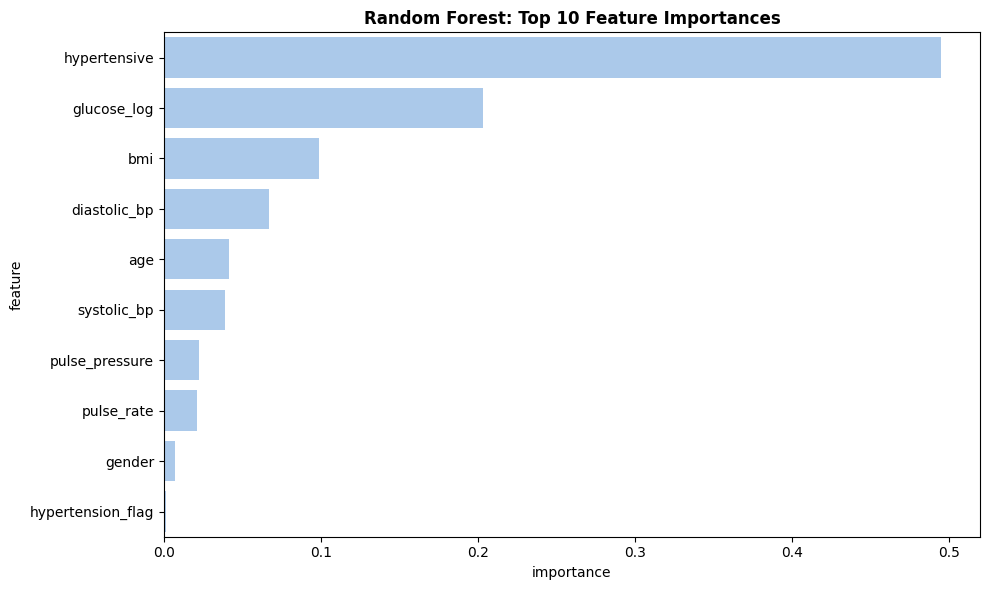


 Random Forest tuning complete!


In [30]:
rf_params = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(5, 21),
    'min_samples_split': randint(2, 21),
    'min_samples_leaf': randint(1, 11),
    'max_features': ['sqrt', 'log2', None]
}

rf_fixed = {'class_weight': 'balanced', 'n_jobs': -1, 'random_state': RANDOM_SEED}

best_rf_score = 0
best_rf_params = None

for i in tqdm(range(30), desc="Random Forest", ncols=100):
    params = {k: (v.rvs() if hasattr(v, 'rvs') else np.random.choice(v))
              for k, v in rf_params.items()}

    model = RandomForestClassifier(**rf_fixed, **params)
    scores = cross_val_score(model, X_train_scaled, y_train_clean,
                            cv=cv, scoring=scoring, n_jobs=-1)

    mean_score = scores.mean()
    if mean_score > best_rf_score:
        best_rf_score = mean_score
        best_rf_params = params

print(f"\n Best CV Score: {best_rf_score:.4f}")
print(f" Best Params: {best_rf_params}")

rf_final = RandomForestClassifier(**rf_fixed, **best_rf_params)
rf_final.fit(X_train_scaled, y_train_clean)

joblib.dump(rf_final, '/content/Random_Forest_best.pkl')
print(" Saved: Random_Forest_best.pkl")

importance = pd.DataFrame({
    'feature': X_train_clean.columns,
    'importance': rf_final.feature_importances_
}).sort_values('importance', ascending=False).head(10)

print("\n Top 10 Features:")
print(importance.to_string(index=False))

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=importance, x='importance', y='feature', ax=ax)
ax.set_title('Random Forest: Top 10 Feature Importances', fontweight='bold')
plt.tight_layout()
plt.show()

## Logistic Regression Tuning

In [31]:
lr_params = {
    'C': uniform(0.001, 10),
    'penalty': ['l1', 'l2']
}

lr_fixed = {
    'class_weight': 'balanced',
    'max_iter': 1000,
    'solver': 'liblinear',
    'random_state': RANDOM_SEED
}

best_lr_score = 0
best_lr_params = None

for i in tqdm(range(30), desc="Logistic Regression", ncols=100):
    params = {k: (v.rvs() if hasattr(v, 'rvs') else np.random.choice(v))
              for k, v in lr_params.items()}

    model = LogisticRegression(**lr_fixed, **params)
    scores = cross_val_score(model, X_train_scaled, y_train_clean,
                            cv=cv, scoring=scoring, n_jobs=-1)

    mean_score = scores.mean()
    if mean_score > best_lr_score:
        best_lr_score = mean_score
        best_lr_params = params

print(f"\n Best CV Score: {best_lr_score:.4f}")
print(f" Best Params: {best_lr_params}")

lr_final = LogisticRegression(**lr_fixed, **best_lr_params)
lr_final.fit(X_train_scaled, y_train_clean)

joblib.dump(lr_final, '/content/Logistic_Regression_best.pkl')
print(" Saved: Logistic_Regression_best.pkl")

Logistic Regression: 100%|██████████████████████████████████████████| 30/30 [00:14<00:00,  2.04it/s]


 Best CV Score: 0.7767
 Best Params: {'C': np.float64(0.006203769953158188), 'penalty': np.str_('l1')}
 Saved: Logistic_Regression_best.pkl


### XGBoost Tuning

XGBoost: 100%|██████████████████████████████████████████████████████| 30/30 [01:08<00:00,  2.27s/it]



 Best CV Score: 0.7803
 Best Params: {'n_estimators': 198, 'max_depth': 3, 'learning_rate': np.float64(0.011518475153865606), 'subsample': np.float64(0.6643232205669994), 'colsample_bytree': np.float64(0.8194935157466344), 'min_child_weight': 6, 'gamma': np.float64(0.22421207149312367), 'tree_method': np.str_('hist')}
 Saved: XGBoost_best.pkl

 Top 10 Features:
          feature  importance
     hypertensive    0.364035
     diastolic_bp    0.078457
      glucose_log    0.070895
hypertension_flag    0.063401
      systolic_bp    0.060399
              bmi    0.057292
  bmi_Underweight    0.044056
              age    0.039313
           gender    0.038360
  family_diabetes    0.030810


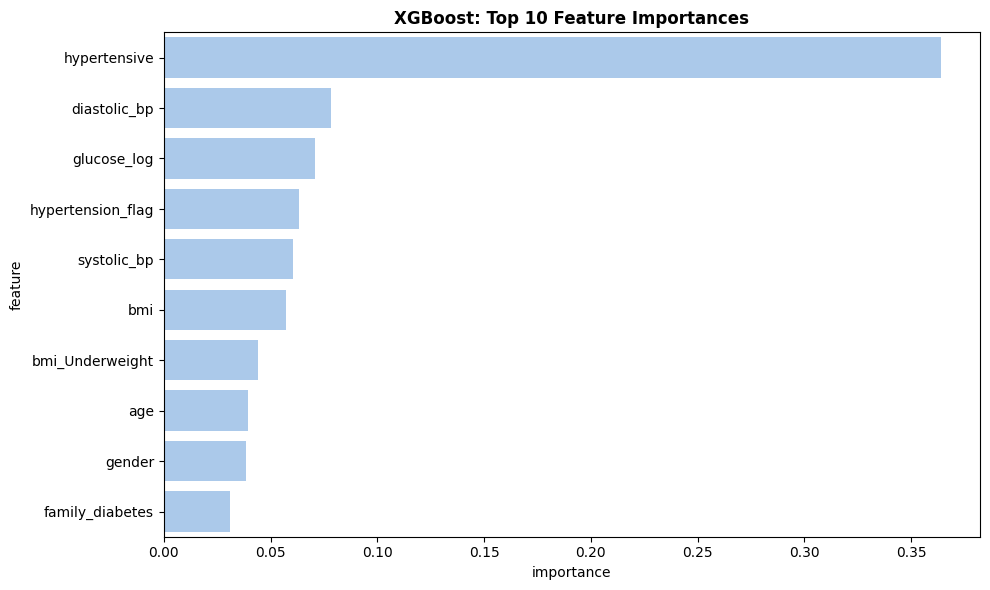

In [32]:
xgb_params = {
    'n_estimators': randint(100, 301),
    'max_depth': randint(3, 11),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'min_child_weight': randint(1, 11),
    'gamma': uniform(0, 0.5),
    'tree_method': ['hist']
}

xgb_fixed = {
    'scale_pos_weight': scale_pos_weight,
    'eval_metric': 'logloss',
    'device': 'cuda' if GPU_AVAILABLE else 'cpu',
    'random_state': RANDOM_SEED
}

best_xgb_score = 0
best_xgb_params = None

for i in tqdm(range(30), desc="XGBoost", ncols=100):
    params = {k: (v.rvs() if hasattr(v, 'rvs') else np.random.choice(v))
              for k, v in xgb_params.items()}

    model = xgb.XGBClassifier(**xgb_fixed, **params)
    scores = cross_val_score(model, X_train_scaled, y_train_clean,
                            cv=cv, scoring=scoring, n_jobs=-1)

    mean_score = scores.mean()
    if mean_score > best_xgb_score:
        best_xgb_score = mean_score
        best_xgb_params = params

print(f"\n Best CV Score: {best_xgb_score:.4f}")
print(f" Best Params: {best_xgb_params}")

xgb_final = xgb.XGBClassifier(**xgb_fixed, **best_xgb_params)
xgb_final.fit(X_train_scaled, y_train_clean)

joblib.dump(xgb_final, '/content/XGBoost_best.pkl')
print(" Saved: XGBoost_best.pkl")

importance = pd.DataFrame({
    'feature': X_train_clean.columns,
    'importance': xgb_final.feature_importances_
}).sort_values('importance', ascending=False).head(10)

print("\n Top 10 Features:")
print(importance.to_string(index=False))

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=importance, x='importance', y='feature', ax=ax)
ax.set_title('XGBoost: Top 10 Feature Importances', fontweight='bold')
plt.tight_layout()
plt.show()

## Final Test Evaluation (Load & Score)

In [33]:
scaler = joblib.load('/content/scaler.pkl')
X_test_scaled = scaler.transform(X_test)

model_files = {
    'Random Forest': '/content/Random_Forest_best.pkl',
    'Logistic Regression': '/content/Logistic_Regression_best.pkl',
    'XGBoost': '/content/XGBoost_best.pkl'
}

final_results = []

for model_name, model_path in model_files.items():
    print(f" Evaluating {model_name}...")

    try:
        model = joblib.load(model_path)

        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

        auc = roc_auc_score(y_test_encoded, y_pred_proba)
        accuracy = (y_pred == y_test_encoded).mean()

        tp = ((y_pred == 1) & (y_test_encoded == 1)).sum()
        fp = ((y_pred == 1) & (y_test_encoded == 0)).sum()
        fn = ((y_pred == 0) & (y_test_encoded == 1)).sum()

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0

        final_results.append({
            'Model': model_name,
            'AUC-ROC': auc,
            'Accuracy': accuracy,
            'Diabetes Precision': precision,
            'Diabetes Recall': recall
        })

        print(f"    AUC-ROC: {auc:.4f}")
        print(f"   - Accuracy: {accuracy:.4f}")
        print(f"   - Diabetes Precision: {precision:.4f}")
        print(f"   - Diabetes Recall: {recall:.4f}")

        print("\n    Classification Report:")
        print(classification_report(y_test_encoded, y_pred,
                                  target_names=['No Diabetes', 'Diabetes'],
                                  digits=4))

        cm = confusion_matrix(y_test_encoded, y_pred)
        print("    Confusion Matrix:")
        print(f"   True Negatives:  {cm[0,0]}")
        print(f"   False Positives: {cm[0,1]}")
        print(f"   False Negatives: {cm[1,0]}")
        print(f"   True Positives:  {cm[1,1]}")
        print("-" * 60)

        predictions_df = pd.DataFrame({
            'true_label': y_test_encoded.values,
            'predicted_label': y_pred,
            'predicted_probability': y_pred_proba
        })
        predictions_df.to_csv(f'/content/{model_name.replace(" ", "_")}_predictions.csv', index=False)
        print(f"    Saved predictions to {model_name.replace(' ', '_')}_predictions.csv\n")

    except FileNotFoundError:
        print(f"    Model file not found: {model_path}")
        print(f"   - Please run the tuning block for {model_name} first")
    except Exception as e:
        print(f"    Error: {e}")

print(" FINAL MODEL COMPARISON SUMMARY:")
summary_df = pd.DataFrame(final_results).sort_values('AUC-ROC', ascending=False)
print(summary_df.to_string(index=False, float_format='%.4f'))

if not summary_df.empty:
    best_model_name = summary_df.iloc[0]['Model']
    best_auc = summary_df.iloc[0]['AUC-ROC']
    print(f"\n BEST MODEL: {best_model_name}")
    print(f"   - Test AUC-ROC: {best_auc:.4f}")
    print("    All models evaluated and saved!")

 Evaluating Random Forest...
    AUC-ROC: 0.8423
   - Accuracy: 0.8648
   - Diabetes Precision: 0.2611
   - Diabetes Recall: 0.6029

    Classification Report:
              precision    recall  f1-score   support

 No Diabetes     0.9700    0.8828    0.9244       990
    Diabetes     0.2611    0.6029    0.3644        68

    accuracy                         0.8648      1058
   macro avg     0.6156    0.7429    0.6444      1058
weighted avg     0.9245    0.8648    0.8884      1058

    Confusion Matrix:
   True Negatives:  874
   False Positives: 116
   False Negatives: 27
   True Positives:  41
------------------------------------------------------------
    Saved predictions to Random_Forest_predictions.csv

 Evaluating Logistic Regression...
    AUC-ROC: 0.8131
   - Accuracy: 0.8270
   - Diabetes Precision: 0.2167
   - Diabetes Recall: 0.6471

    Classification Report:
              precision    recall  f1-score   support

 No Diabetes     0.9719    0.8394    0.9008       990
    D

/usr/local/lib/python3.12/dist-packages/xgboost/core.py:774: UserWarning: [14:36:35] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


## Testing


In [34]:

test_data_final = X_test.copy()
test_data_final['diabetic'] = y_test_encoded.values  # Use the encoded target

print(f" Final test data shape: {test_data_final.shape}")
print(f" Final features: {test_data_final.columns.tolist()}")

test_data_final.to_csv('/content/test_data_final.csv', index=False)
print(" Final processed test data saved: 'test_data_final.csv'")

test_sample_final = X_test.head(5).copy()
test_sample_final['diabetic'] = y_test_encoded.head(5).values
test_sample_final.to_csv('/content/test_sample_final.csv', index=False)
print(" Final test sample saved: 'test_sample_final.csv'")

print(f"   - X_train_clean features: {X_train_clean.columns.tolist()}")
print(f"   - X_test features: {X_test.columns.tolist()}")
print(f"   - Feature match: {list(X_train_clean.columns) == list(X_test.columns)}")


 Final test data shape: (1058, 19)
 Final features: ['age', 'gender', 'pulse_rate', 'systolic_bp', 'diastolic_bp', 'bmi', 'family_diabetes', 'hypertensive', 'family_hypertension', 'cardiovascular_disease', 'stroke', 'pulse_pressure', 'hypertension_flag', 'glucose_log', 'bmi_Normal', 'bmi_Obese', 'bmi_Overweight', 'bmi_Underweight', 'diabetic']
 Final processed test data saved: 'test_data_final.csv'
 Final test sample saved: 'test_sample_final.csv'
   - X_train_clean features: ['age', 'gender', 'pulse_rate', 'systolic_bp', 'diastolic_bp', 'bmi', 'family_diabetes', 'hypertensive', 'family_hypertension', 'cardiovascular_disease', 'stroke', 'pulse_pressure', 'hypertension_flag', 'glucose_log', 'bmi_Normal', 'bmi_Obese', 'bmi_Overweight', 'bmi_Underweight']
   - X_test features: ['age', 'gender', 'pulse_rate', 'systolic_bp', 'diastolic_bp', 'bmi', 'family_diabetes', 'hypertensive', 'family_hypertension', 'cardiovascular_disease', 'stroke', 'pulse_pressure', 'hypertension_flag', 'glucose_log

## Test Input

In [36]:
import pandas as pd
import numpy as np
import joblib
import warnings

SCALER_PATH = "scaler.pkl"
MODEL_PATH = "XGBoost_best.pkl"
MODEL_NAME = "XGBoost"

TEST_DATA = pd.DataFrame(
    [
        {
            "age": 39,
            "gender": 0,
            "pulse_rate": 102,
            "systolic_bp": 123,
            "diastolic_bp": 81.0,
            "bmi": 18.74,
            "family_diabetes": 0,
            "hypertensive": 0,
            "family_hypertension": 0,
            "cardiovascular_disease": 0,
            "stroke": 0,
            "pulse_pressure": 42.0,
            "hypertension_flag": 0,
            "glucose_log": 2.714694743820879,
            "bmi_Normal": True,
            "bmi_Obese": False,
            "bmi_Overweight": False,
            "bmi_Underweight": True,
            "diabetic": 1,
        }
    ]
)

# TEST_DATA = pd.read_csv("test_sample_final.csv")
# TEST_DATA = pd.read_csv("test_data_final.csv").query("diabetic == 1").head(100)

FEATURE_ORDER = [
    "age",
    "gender",
    "pulse_rate",
    "systolic_bp",
    "diastolic_bp",
    "bmi",
    "family_diabetes",
    "hypertensive",
    "family_hypertension",
    "cardiovascular_disease",
    "stroke",
    "pulse_pressure",
    "hypertension_flag",
    "glucose_log",
    "bmi_Normal",
    "bmi_Obese",
    "bmi_Overweight",
    "bmi_Underweight",
]

try:
    warnings.filterwarnings("ignore")

    scaler = joblib.load(SCALER_PATH)
    model = joblib.load(MODEL_PATH)

    print(f"Artifacts Loaded..")

    X_input_df = TEST_DATA
    y_actual = X_input_df["diabetic"]
    # y_actual = 1
    X_features = X_input_df.reindex(columns=FEATURE_ORDER)

    X_array = X_features.astype(
        {
            "bmi_Normal": int,
            "bmi_Obese": int,
            "bmi_Overweight": int,
            "bmi_Underweight": int,
        }
    ).values

    X_scaled = scaler.transform(X_array)

    y_pred = model.predict(X_scaled)
    y_pred_proba = model.predict_proba(X_scaled)[:, 1]

    results_df = pd.DataFrame(
        {
            "Actual": y_actual,
            "Predicted": y_pred,
            "Prob_Diabetes": y_pred_proba.round(4),
        }
    )

    results_df["Actual_Status"] = results_df["Actual"].map(
        {0: "No Diabetes", 1: "DIABETES"}
    )
    results_df["Predicted_Status"] = results_df["Predicted"].map(
        {0: "No Diabetes", 1: "DIABETES"}
    )
    results_df["Correct"] = results_df["Actual"] == results_df["Predicted"]

    final_display_df = results_df.drop(columns=["Actual", "Predicted"])
    final_display_df.index.name = "Sample"

    print(f"Prediction Results using {MODEL_NAME}")

    print(final_display_df.to_string())

    num_correct = final_display_df["Correct"].sum()
    num_total = len(final_display_df)

    print(f" SUMMARY: {num_correct} / {num_total} samples classified correctly.")

    incorrect_results = final_display_df[final_display_df["Correct"] == False]

except Exception as e:
    print(f"\n ERROR occured: {e}")

Artifacts Loaded..
Prediction Results using XGBoost
        Prob_Diabetes Actual_Status Predicted_Status  Correct
Sample                                                       
0              0.6909      DIABETES         DIABETES     True
 SUMMARY: 1 / 1 samples classified correctly.
